<a href="https://colab.research.google.com/github/ElizaChurokova/ds-kg-population-clusters/blob/main/notebook/population_kg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download of the dataset (excel)

In [1]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
filename


Saving Численность населения Кыргызской Республики  на 1 января  2025г...xls to Численность населения Кыргызской Республики  на 1 января  2025г...xls


'Численность населения Кыргызской Республики  на 1 января  2025г...xls'

Connect to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


saving the dataset to drive. So I will use the dataset from the drive

In [128]:
import os
os.makedirs('/content/drive/MyDrive/datasets', exist_ok=True)

# сохраняем файл в Drive
save_path = f'/content/drive/MyDrive/datasets/{'Численность населения Кыргызской Республики  на 1 января  2025г...xls'}'
import shutil
shutil.copy(filename, save_path)

save_path


'/content/drive/MyDrive/datasets/Численность населения Кыргызской Республики  на 1 января  2025г...xls'

Necessary dependencies

In [129]:
# Работа с данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Предобработка
from sklearn.preprocessing import StandardScaler

# PCA для визуализации признаков в 2D
from sklearn.decomposition import PCA

# Иерархическая кластеризация (по желанию)
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# KMeans
from sklearn.cluster import KMeans

# Agglomerative Clustering (иерархическая)
from sklearn.cluster import AgglomerativeClustering

# DBSCAN
from sklearn.cluster import DBSCAN

# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# Метрики для оценки кластеров
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Для снижения размерности и визуализации
from sklearn.decomposition import PCA


# Dataset cleaning

Working with the table. The table is formed in the way, that it needs to be cleaned and reformed

In [130]:
df = pd.read_excel(save_path, header=5)
df.head()


,Unnamed: 0,население,городское,сельское,население.1,городское.1,сельское.1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Кыргызская Республика,7281.8,3037.3,4244.5,6607.1,3000.7,3606.4
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Баткенская область,594.7,185.8,408.9,486.0,161.4,324.6
4,г. Баткен,30.3,30.3,-,27.3,27.3,-


New clear column names

In [131]:
df.columns = ['Region',
              'Permanent_total', 'Permanent_urban', 'Permanent_rural',
              'Actual_total', 'Actual_urban', 'Actual_rural']
df.head(10)


,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Кыргызская Республика,7281.8,3037.3,4244.5,6607.1,3000.7,3606.4
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Баткенская область,594.7,185.8,408.9,486.0,161.4,324.6
4,г. Баткен,30.3,30.3,-,27.3,27.3,-
5,г. Кызыл-Кия,64.1,64.1,-,58.3,58.3,-
6,г. Сулюкта,25.5,25.5,-,21.5,21.5,-
7,Баткенский район,104.2,-,104.2,77.0,-,77
8,Кадамжайский район,214.7,29.9,184.8,178.6,24,154.6
9,в том числе:,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
# удаляем полностью пустые строки
df = df.dropna(how='all')

# удаляем служебные строки типа 'в том числе:', если они есть
df = df[~df['Region'].astype(str).str.contains('в том числе|Источник|Продолжение', na=False)]

# заполним NaN в колонке Region (если merged cells были)
df['Region'] = df['Region'].ffill()

# обрезаем пробелы
df['Region'] = df['Region'].astype(str).str.strip()

df.head(10)


,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
1,Кыргызская Республика,7281.8,3037.3,4244.5,6607.1,3000.7,3606.4
3,Баткенская область,594.7,185.8,408.9,486.0,161.4,324.6
4,г. Баткен,30.3,30.3,-,27.3,27.3,-
5,г. Кызыл-Кия,64.1,64.1,-,58.3,58.3,-
6,г. Сулюкта,25.5,25.5,-,21.5,21.5,-
7,Баткенский район,104.2,-,104.2,77.0,-,77
8,Кадамжайский район,214.7,29.9,184.8,178.6,24,154.6
10,г. Айдаркен,14.2,14.2,-,11.6,11.6,-
11,г. Кадамжай,15.7,15.7,-,12.9,12.9,-
12,Лейлекский район,155.9,36,119.9,123.3,30.3,93


Making the column data numeric: cleaning them from spaces and slashes

In [133]:
cols = ['Permanent_total', 'Permanent_urban', 'Permanent_rural',
        'Actual_total', 'Actual_urban', 'Actual_rural']

for col in cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace('-', '0').str.replace(' ', ''), errors='coerce')

df.head(10)


,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
1,Кыргызская Республика,7281.8,3037.3,4244.5,6607.1,3000.7,3606.4
3,Баткенская область,594.7,185.8,408.9,486.0,161.4,324.6
4,г. Баткен,30.3,30.3,0.0,27.3,27.3,0.0
5,г. Кызыл-Кия,64.1,64.1,0.0,58.3,58.3,0.0
6,г. Сулюкта,25.5,25.5,0.0,21.5,21.5,0.0
7,Баткенский район,104.2,0.0,104.2,77.0,0.0,77.0
8,Кадамжайский район,214.7,29.9,184.8,178.6,24.0,154.6
10,г. Айдаркен,14.2,14.2,0.0,11.6,11.6,0.0
11,г. Кадамжай,15.7,15.7,0.0,12.9,12.9,0.0
12,Лейлекский район,155.9,36.0,119.9,123.3,30.3,93.0


In [134]:
df.Region.unique()

array(['Кыргызская Республика', 'Баткенская область', 'г. Баткен',
       'г. Кызыл-Кия', 'г. Сулюкта', 'Баткенский район',
       'Кадамжайский район', 'г. Айдаркен', 'г. Кадамжай',
       'Лейлекский район', 'г. Раззаков', 'Джалал-Абадская область',
       'г. Джалал -Абад', 'г. Кара-Куль', 'г. Майлуу-Суу', 'г. Таш-Кумыр',
       'Аксыйский район', 'г. Кербен', 'Ала-Букинский район',
       'Базар-Коргонский район', 'г. Базар-Коргон', 'Ноокенский район',
       'г. Кочкор-Ата', 'г. Шамалды- Сай', 'Сузакский район',
       'г. Кок-Жангак', 'Тогуз-Тороуский район', 'Токтогульский район',
       'г. Токтогул', 'Чаткальский район', 'Иссык-Кульская область',
       'г. Каракол', 'г. Балыкчы', 'Ак-Суйский район',
       'Жети-Огузский район', 'Иссык-Кульский район', 'г. Чолпон-Ата',
       'Тонский район', 'Тюпский район', 'Нарынская область', 'г. Нарын',
       'Ак-Талинский район', 'Ат-Башынский район', 'Жумгальский район',
       'Кочкорский район', 'Нарынский район', 'Oшская область',


Deleting the sum and unnecessary columns

In [135]:
df_clean = df[
    ~df['Region'].isin([
        'Кыргызская Республика',
        'Баткенская область',
        'Oшская область',
        'Чуйская область',
        'Таласская область',
        'Нарынская область',
        'Иссык-Кульская область',
        'Джалал-Абадская область',
        'Население постоянное - население, постоянно проживающее на момент переписи на данной территории, включая временно отсутствующих. В межпереписной период производится текущая оценка постоянного населения на базе данных переписи и с учетом сведений текущей регистрации демографических событий.',
        'Население наличное - население, находящееся на момент переписи на данной территории, включая временно проживающих. В межпереписной период производится текущая оценка наличного населения на базе данных переписи и с учетом сведений текущей регистрации демографических событий.'
    ])
]


In [136]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 4 to 94
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           74 non-null     object 
 1   Permanent_total  74 non-null     float64
 2   Permanent_urban  74 non-null     float64
 3   Permanent_rural  73 non-null     float64
 4   Actual_total     74 non-null     float64
 5   Actual_urban     74 non-null     float64
 6   Actual_rural     74 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.6+ KB


In [137]:
df_clean.head(30)

,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
4,г. Баткен,30.3,30.3,0.0,27.3,27.3,0.0
5,г. Кызыл-Кия,64.1,64.1,0.0,58.3,58.3,0.0
6,г. Сулюкта,25.5,25.5,0.0,21.5,21.5,0.0
7,Баткенский район,104.2,0.0,104.2,77.0,0.0,77.0
8,Кадамжайский район,214.7,29.9,184.8,178.6,24.0,154.6
10,г. Айдаркен,14.2,14.2,0.0,11.6,11.6,0.0
11,г. Кадамжай,15.7,15.7,0.0,12.9,12.9,0.0
12,Лейлекский район,155.9,36.0,119.9,123.3,30.3,93.0
13,г. Раззаков,36.0,36.0,0.0,30.3,30.3,0.0
16,г. Джалал -Абад,184.4,184.4,0.0,181.1,181.1,0.0


In [138]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 4 to 94
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           74 non-null     object 
 1   Permanent_total  74 non-null     float64
 2   Permanent_urban  74 non-null     float64
 3   Permanent_rural  73 non-null     float64
 4   Actual_total     74 non-null     float64
 5   Actual_urban     74 non-null     float64
 6   Actual_rural     74 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.6+ KB


Nan->0.0 (because Osh is a city, no data is needed for rural)

In [139]:
df_clean[df_clean['Permanent_rural'].isna()]


,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
94,г. Ош,0.0,0.0,NaN,0.0,0.0,0.0


In [140]:
df_clean

,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
4,г. Баткен,30.3,30.3,0.0,27.3,27.3,0.0
5,г. Кызыл-Кия,64.1,64.1,0.0,58.3,58.3,0.0
6,г. Сулюкта,25.5,25.5,0.0,21.5,21.5,0.0
7,Баткенский район,104.2,0.0,104.2,77.0,0.0,77.0
8,Кадамжайский район,214.7,29.9,184.8,178.6,24.0,154.6
...,...,...,...,...,...,...,...
87,Чуйский район,61.3,0.0,61.3,55.0,0.0,55.0
88,Ысык-Атинский район,130.2,0.0,130.2,134.4,0.0,134.4
90,г. Бишкек,1321.9,1321.9,0.0,1338.9,1338.9,0.0
92,г. Ош,473.5,473.5,0.0,484.5,484.5,0.0


In [141]:
df_clean.Permanent_rural = df_clean.Permanent_rural.fillna(0.0)

/tmp/ipython-input-3353372615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.Permanent_rural = df_clean.Permanent_rural.fillna(0.0)


In [142]:
df_clean

,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
4,г. Баткен,30.3,30.3,0.0,27.3,27.3,0.0
5,г. Кызыл-Кия,64.1,64.1,0.0,58.3,58.3,0.0
6,г. Сулюкта,25.5,25.5,0.0,21.5,21.5,0.0
7,Баткенский район,104.2,0.0,104.2,77.0,0.0,77.0
8,Кадамжайский район,214.7,29.9,184.8,178.6,24.0,154.6
...,...,...,...,...,...,...,...
87,Чуйский район,61.3,0.0,61.3,55.0,0.0,55.0
88,Ысык-Атинский район,130.2,0.0,130.2,134.4,0.0,134.4
90,г. Бишкек,1321.9,1321.9,0.0,1338.9,1338.9,0.0
92,г. Ош,473.5,473.5,0.0,484.5,484.5,0.0


Deleting the duplicate row with zeros

In [143]:
numeric_cols = df_clean.select_dtypes(include='number').columns

df_clean = df_clean[~(df_clean[numeric_cols].sum(axis=1) == 0)]


In [144]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 4 to 92
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           73 non-null     object 
 1   Permanent_total  73 non-null     float64
 2   Permanent_urban  73 non-null     float64
 3   Permanent_rural  73 non-null     float64
 4   Actual_total     73 non-null     float64
 5   Actual_urban     73 non-null     float64
 6   Actual_rural     73 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.6+ KB


In [145]:
df_clean.head(70)

,Region,Permanent_total,Permanent_urban,Permanent_rural,Actual_total,Actual_urban,Actual_rural
4,г. Баткен,30.3,30.3,0.0,27.3,27.3,0.0
5,г. Кызыл-Кия,64.1,64.1,0.0,58.3,58.3,0.0
6,г. Сулюкта,25.5,25.5,0.0,21.5,21.5,0.0
7,Баткенский район,104.2,0.0,104.2,77.0,0.0,77.0
8,Кадамжайский район,214.7,29.9,184.8,178.6,24.0,154.6
...,...,...,...,...,...,...,...
83,Панфиловский район,51.4,10.8,40.6,45.3,9.5,35.8
84,г. Каинды,10.8,10.8,0.0,9.5,9.5,0.0
85,Сокулукский район,227.2,11.1,216.1,211.8,10.6,201.2
86,г. Шопоков,11.1,11.1,0.0,10.6,10.6,0.0


Deleting the total columns

In [146]:
df_clean = df_clean.drop(columns=['Permanent_total', 'Actual_total'])


Checking the dataset

In [147]:
df_clean.isna().sum()


,0
Region,0
Permanent_urban,0
Permanent_rural,0
Actual_urban,0
Actual_rural,0


Extra feature

In [148]:
df_clean['urban_ratio'] = df_clean['Permanent_urban'] / (
    df_clean['Permanent_urban'] + df_clean['Permanent_rural']
)
df_clean['rural_ratio'] = 1 - df_clean['urban_ratio']



In [149]:
df_clean

,Region,Permanent_urban,Permanent_rural,Actual_urban,Actual_rural,urban_ratio,rural_ratio
4,г. Баткен,30.3,0.0,27.3,0.0,1.000000,0.000000
5,г. Кызыл-Кия,64.1,0.0,58.3,0.0,1.000000,0.000000
6,г. Сулюкта,25.5,0.0,21.5,0.0,1.000000,0.000000
7,Баткенский район,0.0,104.2,0.0,77.0,0.000000,1.000000
8,Кадамжайский район,29.9,184.8,24.0,154.6,0.139264,0.860736
...,...,...,...,...,...,...,...
86,г. Шопоков,11.1,0.0,10.6,0.0,1.000000,0.000000
87,Чуйский район,0.0,61.3,0.0,55.0,0.000000,1.000000
88,Ысык-Атинский район,0.0,130.2,0.0,134.4,0.000000,1.000000
90,г. Бишкек,1321.9,0.0,1338.9,0.0,1.000000,0.000000


Standartizing - Scaling

In [150]:
numerical_columns = df_clean.select_dtypes(include='number').columns.tolist()


In [151]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[numerical_columns])


# Data analysis

min, max, std info

In [152]:
df_clean.describe()


,Permanent_urban,Permanent_rural,Actual_urban,Actual_rural,urban_ratio,rural_ratio
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,47.889041,58.143836,46.716438,49.402740,0.490564,0.509436
std,162.859113,77.501550,165.162680,66.561521,0.473436,0.473436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.700000,35.500000,12.900000,29.600000,0.305666,0.694334
75%,37.100000,94.500000,40.300000,71.900000,1.000000,1.000000
max,1321.900000,341.600000,1338.900000,290.600000,1.000000,1.000000


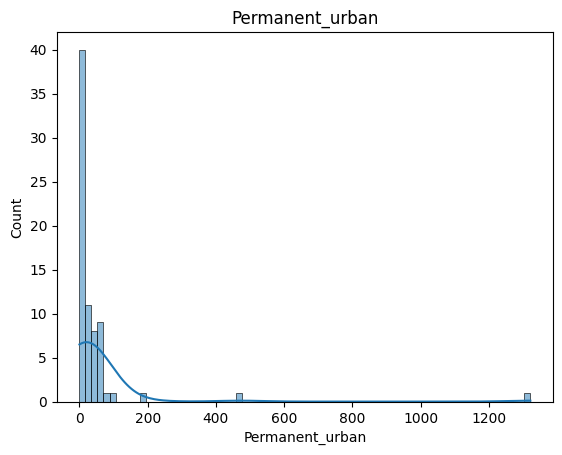

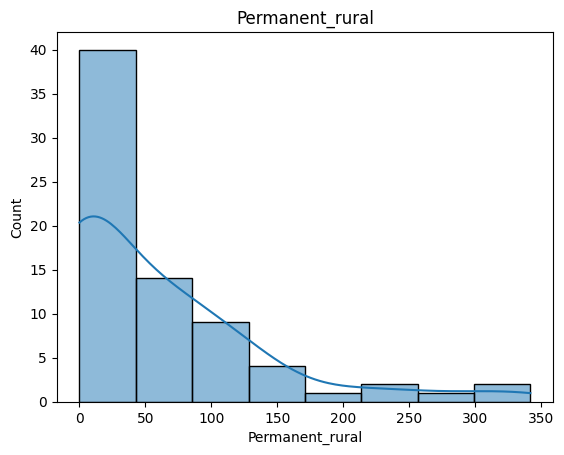

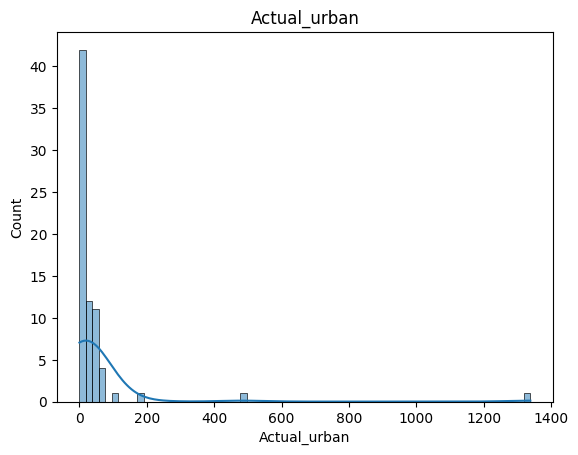

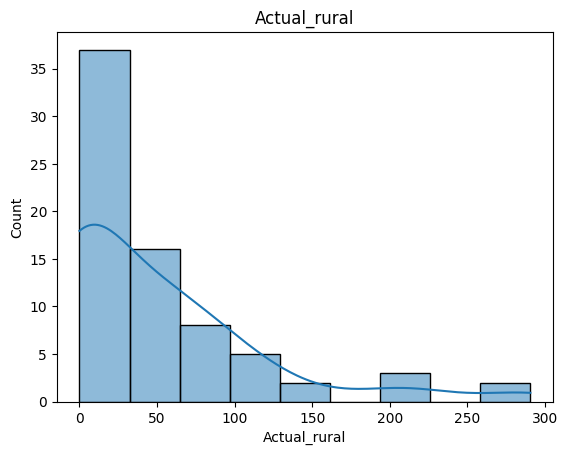

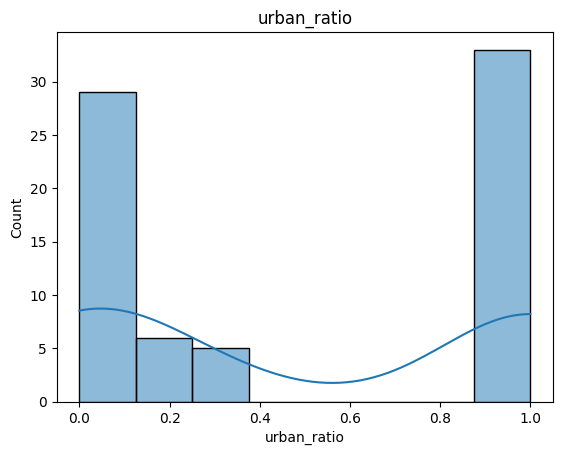

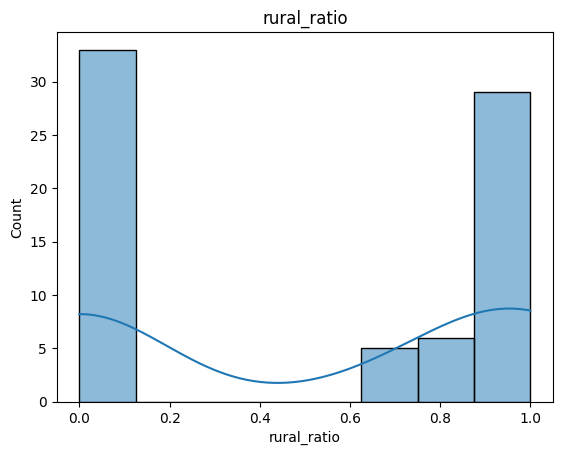

In [153]:
numeric_cols = df_clean.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure()
    sns.histplot(df_clean[col], kde=True)
    plt.title(col)
    plt.show()


correlation

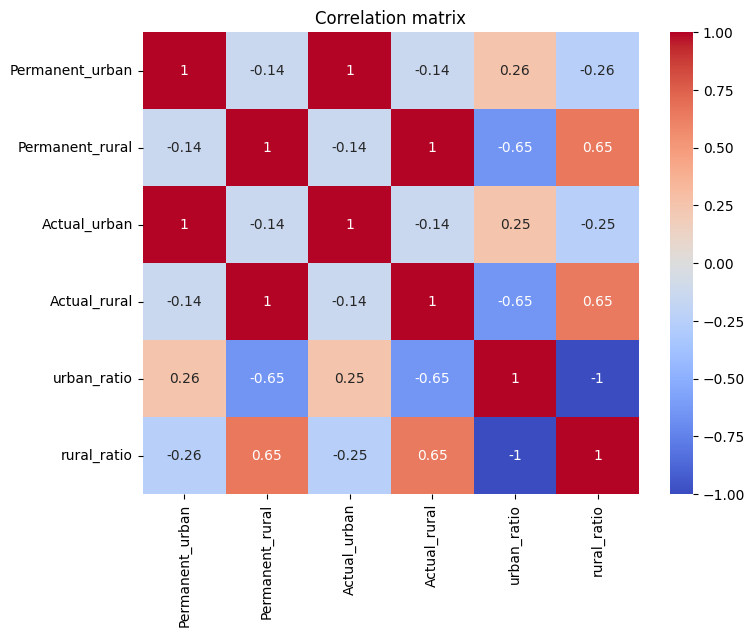

In [154]:
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


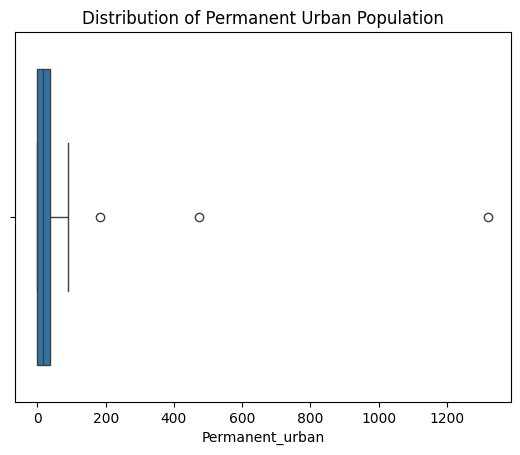

In [155]:
sns.boxplot(x='Permanent_urban', data=df_clean)
plt.title('Distribution of Permanent Urban Population')
plt.show()


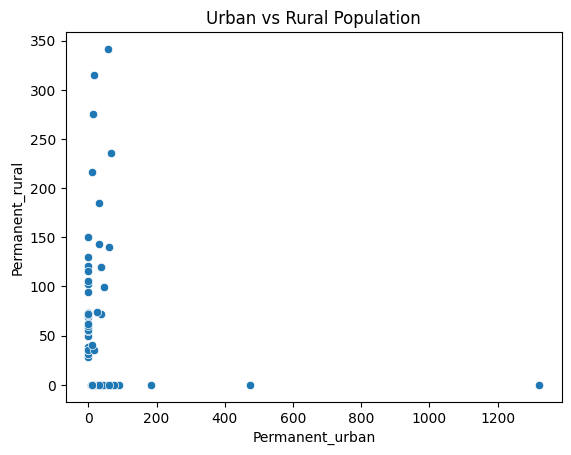

In [156]:
sns.scatterplot(x='Permanent_urban', y='Permanent_rural', data=df_clean)
plt.title('Urban vs Rural Population')
plt.show()


# Models

In [161]:
# KMeans
# -------------------------------
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_clean['KMeans'] = kmeans.fit_predict(X_scaled)

# Метрики
print("KMeans Metrics:")
print("Silhouette:", silhouette_score(X_scaled, df_clean['KMeans']))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, df_clean['KMeans']))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, df_clean['KMeans']))
print("\n")

# -------------------------------
# Agglomerative Clustering
# -------------------------------
agglo = AgglomerativeClustering(n_clusters=k)
df_clean['Agglomerative'] = agglo.fit_predict(X_scaled)

# Метрики
print("Agglomerative Metrics:")
print("Silhouette:", silhouette_score(X_scaled, df_clean['Agglomerative']))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, df_clean['Agglomerative']))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, df_clean['Agglomerative']))
print("\n")

# -------------------------------
# DBSCAN
# -------------------------------
dbscan = DBSCAN(eps=1.5, min_samples=2)  # пример eps
df_clean['DBSCAN'] = dbscan.fit_predict(X_scaled)

# Метрики (если есть кластеры >1)
labels_db = df_clean['DBSCAN'].values
if len(set(labels_db)) > 1:
    print("DBSCAN Metrics:")
    print("Silhouette:", silhouette_score(X_scaled, labels_db))
    print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, labels_db))
    print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_db))
print("\n")

# -------------------------------
# Gaussian Mixture Model (GMM)
# -------------------------------
gmm = GaussianMixture(n_components=k, random_state=42)
df_clean['GMM'] = gmm.fit_predict(X_scaled)

# Метрики
print("GMM Metrics:")
print("Silhouette:", silhouette_score(X_scaled, df_clean['GMM']))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, df_clean['GMM']))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, df_clean['GMM']))
print("\n")

# -------------------------------
# Вывод таблицы с результатами
# -------------------------------
df_results = df_clean[['Region', 'KMeans', 'Agglomerative', 'DBSCAN', 'GMM']]
df_results


KMeans Metrics:
Silhouette: 0.698324391853264
Calinski-Harabasz: 60.29147258199136
Davies-Bouldin: 0.47961010449579683


Agglomerative Metrics:
Silhouette: 0.6953271287716873
Calinski-Harabasz: 117.68488570742792
Davies-Bouldin: 0.32102356141479815


DBSCAN Metrics:
Silhouette: 0.6986287658299224
Calinski-Harabasz: 99.95670272890045
Davies-Bouldin: 0.5527105685394393


GMM Metrics:
Silhouette: 0.698324391853264
Calinski-Harabasz: 60.29147258199136
Davies-Bouldin: 0.47961010449579683




,Region,KMeans,Agglomerative,DBSCAN,GMM
4,г. Баткен,0,1,0,0
5,г. Кызыл-Кия,0,1,0,0
6,г. Сулюкта,0,1,0,0
7,Баткенский район,1,0,1,1
8,Кадамжайский район,2,0,1,2
...,...,...,...,...,...
86,г. Шопоков,0,1,0,0
87,Чуйский район,1,0,1,1
88,Ысык-Атинский район,1,0,1,1
90,г. Бишкек,0,2,-1,0


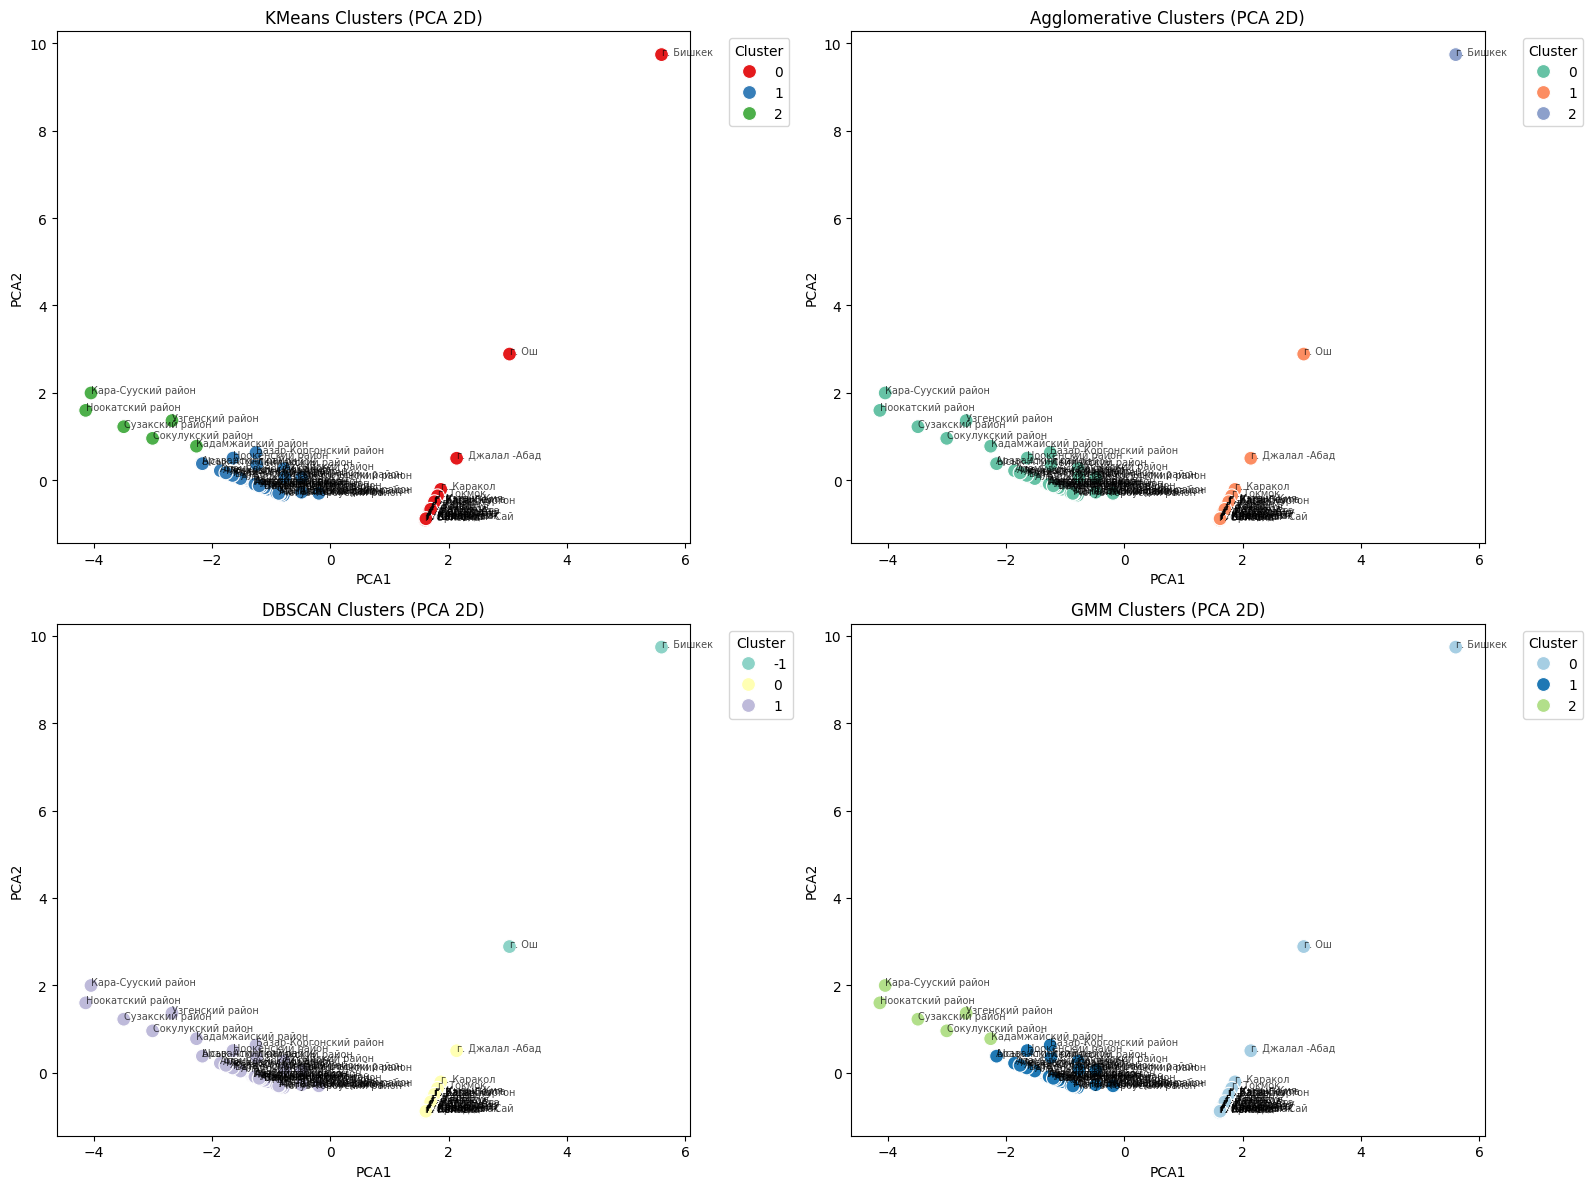

In [159]:
plt.figure(figsize=(16,12))

models = ['KMeans', 'Agglomerative', 'DBSCAN', 'GMM']
palettes = ['Set1', 'Set2', 'Set3', 'Paired']  # заменили Set4 на Paired

for i, model in enumerate(models):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(
        x=X_pca[:,0],
        y=X_pca[:,1],
        hue=df_clean[model],
        palette=palettes[i],
        s=100,
        legend='full'
    )
    for j, txt in enumerate(df_clean['Region']):
        plt.annotate(txt, (X_pca[j,0], X_pca[j,1]), fontsize=7, alpha=0.7)
    plt.title(f'{model} Clusters (PCA 2D)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


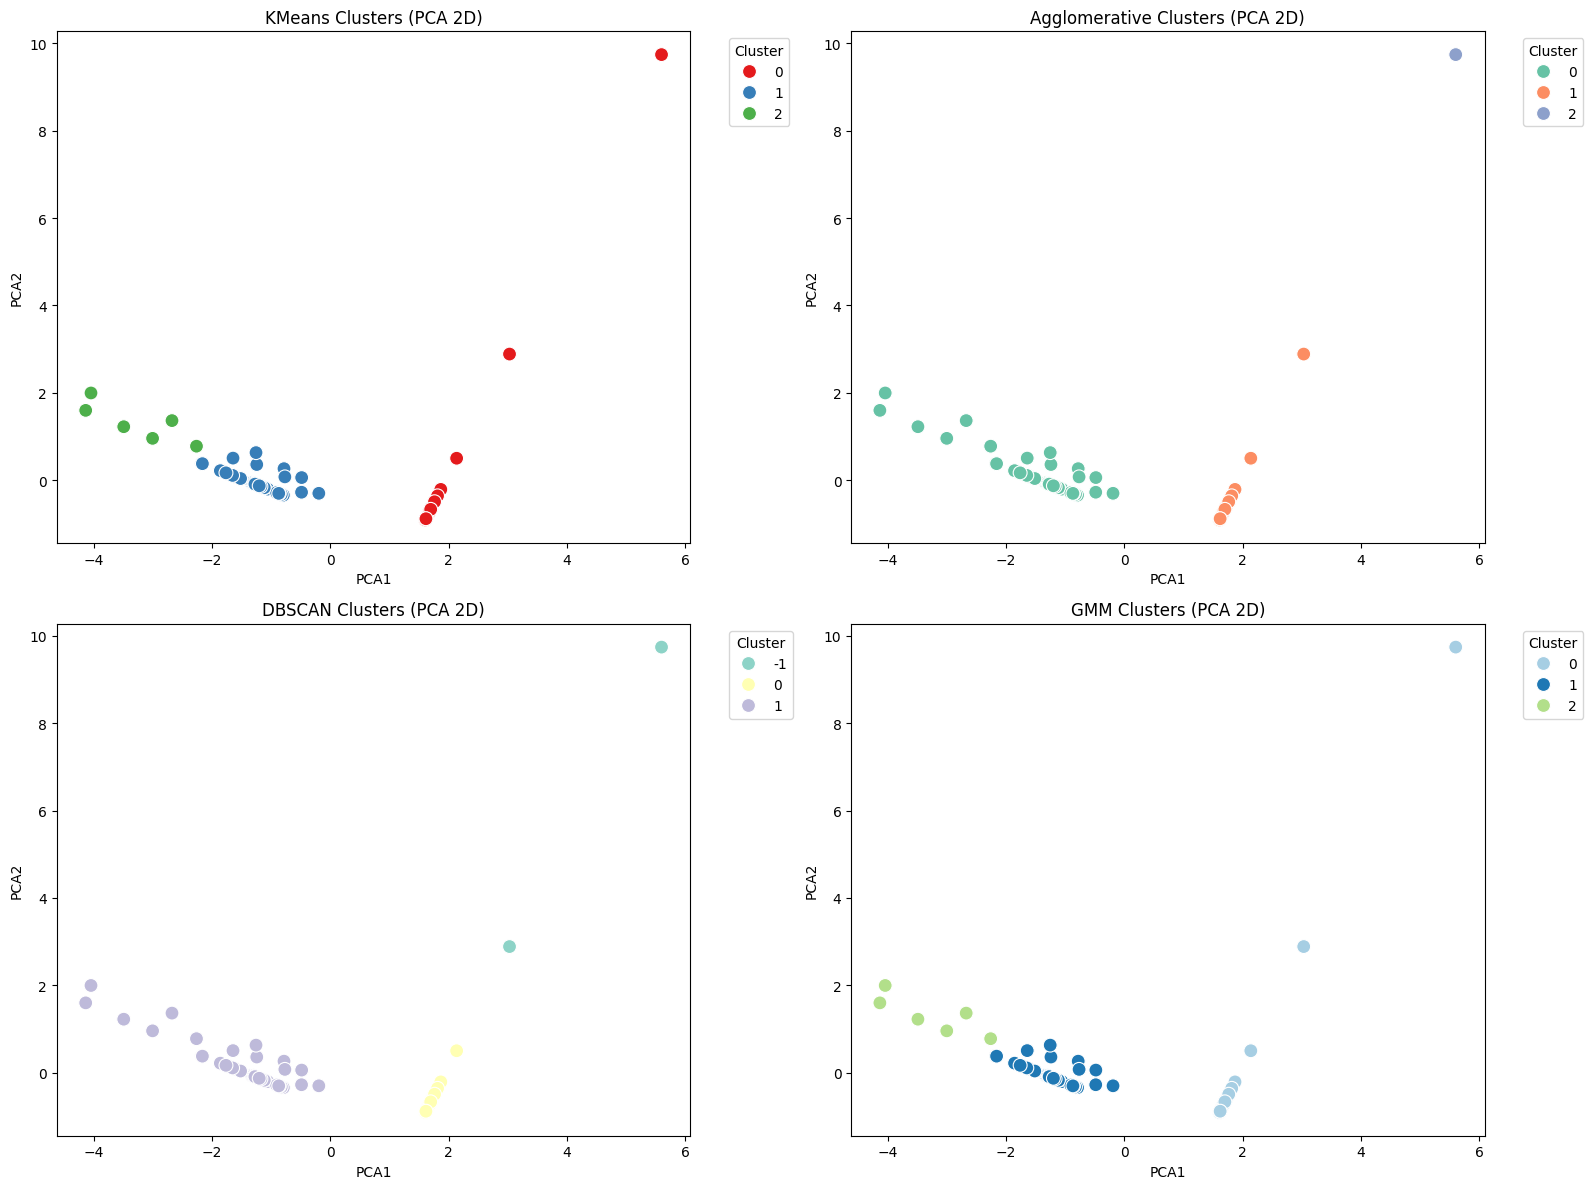


===== KMeans clusters =====
Cluster 0 (33): ['г. Баткен', 'г. Кызыл-Кия', 'г. Сулюкта', 'г. Айдаркен', 'г. Кадамжай', 'г. Раззаков', 'г. Джалал -Абад', 'г. Кара-Куль', 'г. Майлуу-Суу', 'г. Таш-Кумыр', 'г. Кербен', 'г. Базар-Коргон', 'г. Кочкор-Ата', 'г. Шамалды- Сай', 'г. Кок-Жангак', 'г. Токтогул', 'г. Каракол', 'г. Балыкчы', 'г. Чолпон-Ата', 'г. Нарын', 'г. Кара-Суу', 'г. Ноокат', 'г. Узген', 'г. Талас', 'г. Токмок', 'г. Кара-Балта', 'г. Кант', 'г. Кемин', 'г. Орловка', 'г. Каинды', 'г. Шопоков', 'г. Бишкек', 'г. Ош']
Cluster 1 (34): ['Баткенский район', 'Лейлекский район', 'Аксыйский район', 'Ала-Букинский район', 'Базар-Коргонский район', 'Ноокенский район', 'Тогуз-Тороуский район', 'Токтогульский район', 'Чаткальский район', 'Ак-Суйский район', 'Жети-Огузский район', 'Иссык-Кульский район', 'Тонский район', 'Тюпский район', 'Ак-Талинский район', 'Ат-Башынский район', 'Жумгальский район', 'Кочкорский район', 'Нарынский район', 'Алайский район', 'Араванский район', 'Кара-Кулжинский

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
#  PCA scatter plots без подписей
# -------------------------------
plt.figure(figsize=(16,12))

models = ['KMeans', 'Agglomerative', 'DBSCAN', 'GMM']
palettes = ['Set1', 'Set2', 'Set3', 'Paired']

for i, model in enumerate(models):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(
        x=X_pca[:,0],
        y=X_pca[:,1],
        hue=df_clean[model],
        palette=palettes[i],
        s=100,
        legend='full'
    )
    plt.title(f'{model} Clusters (PCA 2D)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# -------------------------------
# Списки районов по кластерам
# -------------------------------
for model in models:
    print(f'\n===== {model} clusters =====')
    for cluster in sorted(df_clean[model].unique()):
        regions = df_clean[df_clean[model]==cluster]['Region'].tolist()
        print(f'Cluster {cluster} ({len(regions)}): {regions}')
